# Installing transformer datasets

In [1]:
!pip install torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from datasets import load_dataset #library provides easy access to a wide range of public datasets
                                  #Here, it will be used to load a text dataset (likely the IMDb dataset).
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset # Dataloader allows to easily process data in batches during training
import numpy as np

# 1. Define the Positional Encoding

In [3]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1), :]
#         return x


## 1. Define the Positional Encoding

$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$ , $PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        print(f"Initializing PositionalEncoding with d_model={d_model}, max_len={max_len}")

        # Step 1: Initialize the positional encoding tensor
        pe = torch.zeros(max_len, d_model)
        print(f"Step 1: Initialized pe tensor with shape: {pe.shape}")

        # Step 2: Create a tensor for positions
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        print(f"Step 2: Created position tensor with shape: {position.shape}")
        # print(f"First 5 positions: {position[:5].squeeze()}")

        # Step 3: Calculate the division term
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        print(f"Step 3: Calculated div_term tensor with shape: {div_term.shape}")
        # print(f"First 5 div_term values: {div_term[:5]}")

        # Step 4: Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        print(f"Step 4: Applied sine to even indices of pe")
        # print(f"First row, even indices of pe: {pe[0, 0::2][:5]}")

        # Step 5: Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        print(f"Step 5: Applied cosine to odd indices of pe")
        # print(f"First row, odd indices of pe: {pe[0, 1::2][:5]}")

        # Step 6: Add a batch dimension
        pe = pe.unsqueeze(0)
        print(f"Step 6: Added batch dimension to pe, new shape: {pe.shape}")

        # Step 7: Register as a buffer
        self.register_buffer('pe', pe)
        print(f"Step 7: Registered pe as a buffer")

    def forward(self, x):
        print(f"Forward Pass: Input tensor x has shape: {x.shape}")
        # Step 8: Select relevant positional encodings
        pe_to_add = self.pe[:, :x.size(1), :]
        print(f"Step 8: Selected positional encodings with shape: {pe_to_add.shape}")

        # Step 9: Add positional encoding to input
        x = x + pe_to_add
        print(f"Step 9: Added positional encoding to input. Output shape: {x.shape}")
        return x

# Demonstrate Positional Encoding with a sample tensor
# Define parameters for the demonstration
d_model_demo = 64  # Embedding dimension
max_len_demo = 100 # Maximum sequence length
batch_size_demo = 2
seq_length_demo = 10 # Actual sequence length of the sample input

# Create a dummy input tensor (e.g., representing embeddings)
# Shape is (batch_size, sequence_length, d_model)
sample_input = torch.randn(batch_size_demo, seq_length_demo, d_model_demo)
print(f"\nCreated sample input tensor with shape: {sample_input.shape}")

# Initialize the PositionalEncoding module
pos_encoder_demo = PositionalEncoding(d_model_demo, max_len_demo)

# Apply positional encoding to the sample input
output_with_pe = pos_encoder_demo(sample_input)

print(f"\nOriginal sample input (first item, first token, first 5 dimensions):\n{sample_input[0, 0, :5]}")
print(f"Positional Encoding added (first item, first token, first 5 dimensions):\n{pos_encoder_demo.pe[0, 0, :5]}")
print(f"Output tensor with PE (first item, first token, first 5 dimensions):\n{output_with_pe[0, 0, :5]}")

# Verify that the output is the sum of the input and the corresponding PE
print(f"\nVerification: Does output[0, 0, :5] == input[0, 0, :5] + PE[0, 0, :5]?")
print(output_with_pe[0, 0, :5] == sample_input[0, 0, :5] + pos_encoder_demo.pe[0, 0, :5])


Created sample input tensor with shape: torch.Size([2, 10, 64])
Initializing PositionalEncoding with d_model=64, max_len=100
Step 1: Initialized pe tensor with shape: torch.Size([100, 64])
Step 2: Created position tensor with shape: torch.Size([100, 1])
Step 3: Calculated div_term tensor with shape: torch.Size([32])
Step 4: Applied sine to even indices of pe
Step 5: Applied cosine to odd indices of pe
Step 6: Added batch dimension to pe, new shape: torch.Size([1, 100, 64])
Step 7: Registered pe as a buffer
Forward Pass: Input tensor x has shape: torch.Size([2, 10, 64])
Step 8: Selected positional encodings with shape: torch.Size([1, 10, 64])
Step 9: Added positional encoding to input. Output shape: torch.Size([2, 10, 64])

Original sample input (first item, first token, first 5 dimensions):
tensor([-0.0610, -0.2569,  1.1972,  0.3172, -1.7445])
Positional Encoding added (first item, first token, first 5 dimensions):
tensor([0., 1., 0., 1., 0.])
Output tensor with PE (first item, first 


Visualizing Positional Encoding:
Shape of positional encoding buffer for plotting: (100, 64)


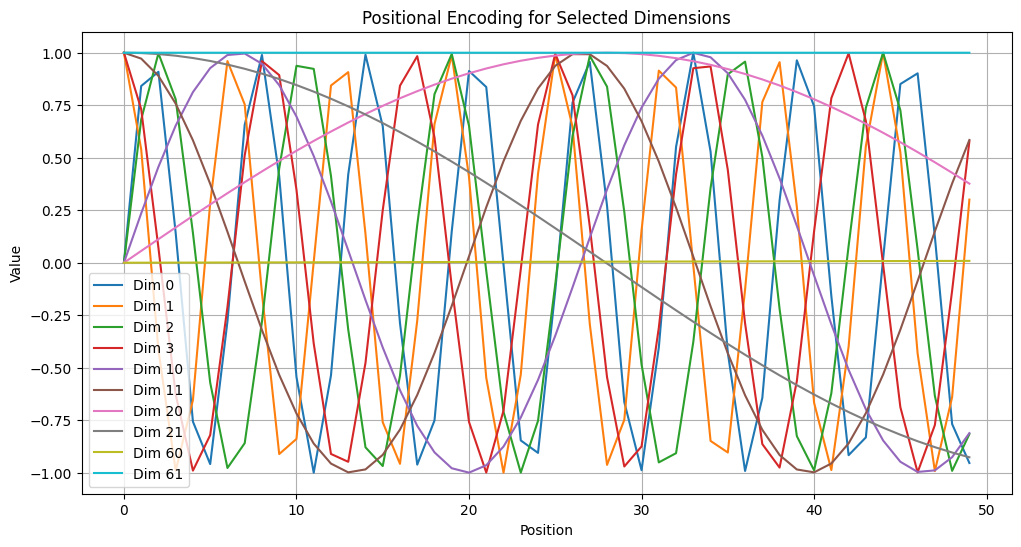

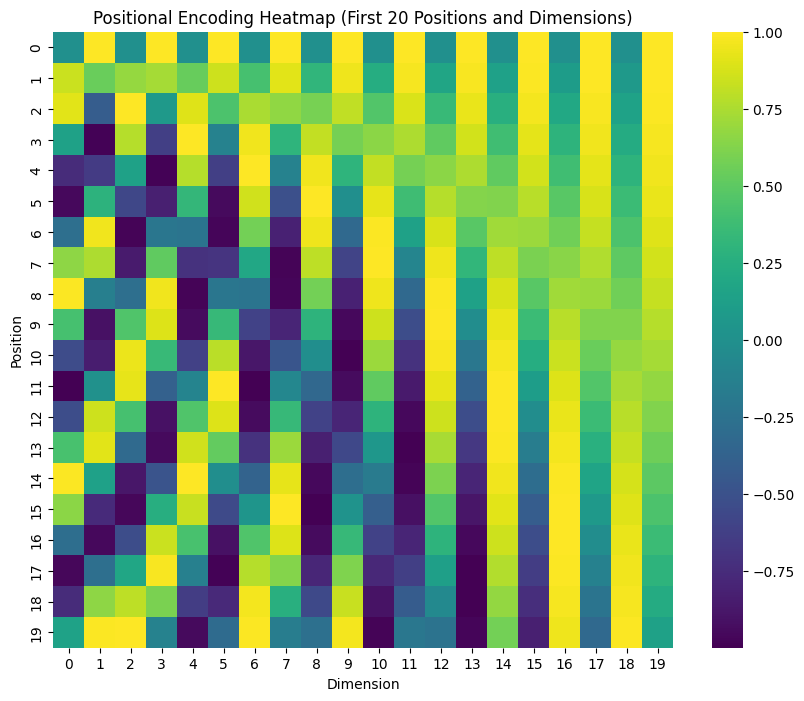

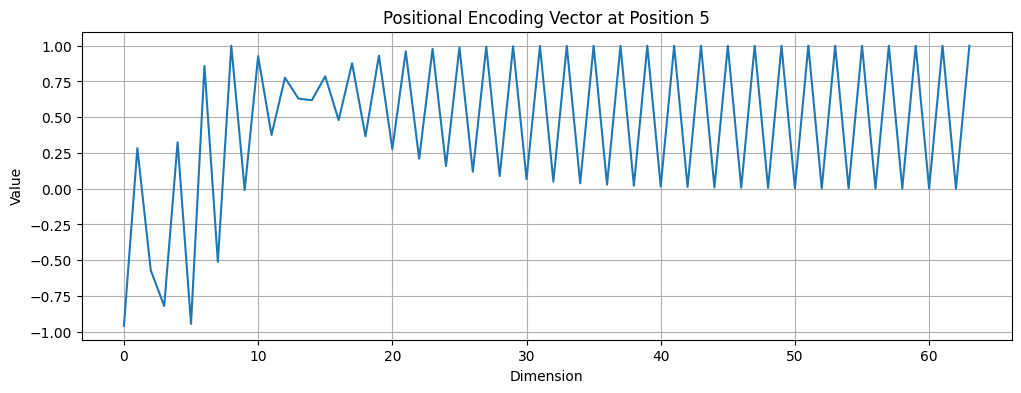

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming PositionalEncoding class is already defined and the instance pos_encoder_demo exists
# And assuming the pe buffer has been populated during initialization

# Get the positional encoding buffer
pe_buffer = pos_encoder_demo.pe.squeeze(0).cpu().numpy() # Remove batch dimension and move to CPU for numpy

print(f"\nVisualizing Positional Encoding:")
print(f"Shape of positional encoding buffer for plotting: {pe_buffer.shape}")

# Plotting a few dimensions across different positions
plt.figure(figsize=(12, 6))
dimensions_to_plot = [0, 1, 2, 3, 10, 11, 20, 21, 60, 61] # Select a few dimensions to show frequency changes
for dim in dimensions_to_plot:
    plt.plot(pe_buffer[:50, dim], label=f'Dim {dim}') # Plot the first 50 positions

plt.title('Positional Encoding for Selected Dimensions')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting as a heatmap to see the pattern for the first few positions and dimensions
plt.figure(figsize=(10, 8))
# Select the first few positions and dimensions for the heatmap
sns.heatmap(pe_buffer[:20, :20], cmap='viridis', annot=False, cbar=True)
plt.title('Positional Encoding Heatmap (First 20 Positions and Dimensions)')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.show()

# Plotting a single positional encoding vector (e.g., at position 5)
position_to_plot = 5
plt.figure(figsize=(12, 4))
plt.plot(pe_buffer[position_to_plot, :])
plt.title(f'Positional Encoding Vector at Position {position_to_plot}')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Plot Selected Dimensions:

  It creates a line plot showing the positional encoding values for a few selected dimensions (dimensions_to_plot) across the first 50 positions.
  This plot demonstrates how different dimensions have different frequencies, allowing the model to distinguish between positions. Lower dimensions tend to have lower frequencies (longer wavelengths), while higher dimensions have higher frequencies (shorter wavelengths).

Plot Heatmap:

  It generates a heatmap of the positional encoding buffer for the first 20 positions and the first 20 dimensions.
  The heatmap provides a visual representation of the entire pattern of the positional encodings across these dimensions and positions. You can clearly see the alternating sine and cosine patterns.

Plot Single Vector:

  It plots the positional encoding vector for a specific position (here, position 5).
  This shows the specific combination of values across all dimensions that represents this particular position.



# 2. Define the Transformer Encoder Model for Classification

In [4]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length, num_classes):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, src, src_mask=None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output.mean(dim=1)  # Global average pooling
        output = self.dropout(output)
        output = self.fc(output)
        return output



###Tokenization and Input IDs:
The tokenizer_demo takes the raw text string and performs two main actions:
  It breaks the text into smaller units called tokens (e.g., "This", "is", "a", "sample", "sentence", ".", plus special tokens like [CLS] at the start and [SEP] at the end).
  It then looks up each token in its vocabulary and assigns a unique integer ID to it.
  It adds padding tokens ([PAD]) if the sequence is shorter than max_seq_length_demo to make all sequences the same length.
  The result is a tensor of integer IDs (input_ids_demo) with the shape (batch_size, max_seq_length). In our simple example with one sentence, the batch size is 1.
###Embedding Layer:
The embedding_layer_demo takes this tensor of integer IDs. For each ID, it acts like a lookup table:
  It finds the corresponding pre-defined or learned vector representation for that specific token ID.
  These vectors are d_model_demo dimensions long.
  The output is a new tensor embedding_output_demo with the shape (batch_size, max_seq_length, d_model). Each position in the sequence now has a vector representation instead of a simple ID.


In [22]:
# Import necessary libraries
import torch
import torch.nn as nn
from transformers import BertTokenizer

# --- Demonstration of Embedding Function ---

# Define parameters (should match those used in your model)
vocab_size_demo = 30522  # BERT tokenizer vocab size
d_model_demo = 128       # Embedding dimension
max_seq_length_demo = 128 # Maximum sequence length for tokenization

# Initialize the BERT tokenizer
tokenizer_demo = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the Embedding layer
# This layer will learn to map each token ID to a d_model-dimensional vector
embedding_layer_demo = nn.Embedding(vocab_size_demo, d_model_demo)

# Sample input text
sample_text = "This is a sample sentence for embedding."
print(f"Original text: '{sample_text}'")

# Step 1: Tokenize the text and convert to input IDs
# The tokenizer handles splitting the text into tokens and mapping them to their IDs.
# We use return_tensors='pt' to get PyTorch tensors.
# padding='max_length' and truncation=True ensure the output is fixed length.
encoding_demo = tokenizer_demo(
    sample_text,
    add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
    max_length=max_seq_length_demo,
    padding='max_length',
    truncation=True,
    return_tensors='pt' # Returns PyTorch tensors
)

# Get the input IDs tensor
input_ids_demo = encoding_demo['input_ids']

print(f"\nStep 1: Text tokenized and converted to Input IDs.")
print(f"Input IDs tensor shape: {input_ids_demo.shape}")
print(f"Input IDs (first 10): {input_ids_demo[0, :10]}") # Show the first batch item, first 10 IDs
print(f"Input ID for [CLS] token: {tokenizer_demo.cls_token_id}")
print(f"Input ID for [SEP] token: {tokenizer_demo.sep_token_id}")
print(f"Input ID for [PAD] token: {tokenizer_demo.pad_token_id}")

# Step 2: Pass the Input IDs through the Embedding layer
# The embedding layer looks up the vector associated with each ID.
embedding_output_demo = embedding_layer_demo(input_ids_demo)

print(f"\nStep 2: Input IDs passed through the Embedding layer.")
print(f"Embedding output tensor shape: {embedding_output_demo.shape}")
# The shape is (batch_size, sequence_length, d_model)

# Step 3: Inspect a sample embedding vector
# Let's look at the embedding vector for the first token ([CLS] token at position 0)
first_token_embedding = embedding_output_demo[0, 0, :] # Batch 0, position 0, all dimensions
print(f"\nStep 3: Inspecting the embedding vector for the first token.")
print(f"Shape of the first token's embedding vector: {first_token_embedding.shape}")
print(f"First 10 values of the first token's embedding vector:\n{first_token_embedding[:10]}")

# You can also look at the embedding for another token, e.g., the word "sample"
# Find the ID for "sample" and its position (might require inspecting the tokens)
# For simplicity, let's assume "sample" is at index 4 in our token list based on printout
# (Note: This index can vary based on the exact tokenization)
# sample_token_embedding = embedding_output_demo[0, 4, :]
# print(f"\nFirst 10 values of the 'sample' token's embedding vector (assuming index 4):\n{sample_token_embedding[:10]}")

Original text: 'This is a sample sentence for embedding.'

Step 1: Text tokenized and converted to Input IDs.
Input IDs tensor shape: torch.Size([1, 128])
Input IDs (first 10): tensor([ 101, 2023, 2003, 1037, 7099, 6251, 2005, 7861, 8270, 4667])
Input ID for [CLS] token: 101
Input ID for [SEP] token: 102
Input ID for [PAD] token: 0

Step 2: Input IDs passed through the Embedding layer.
Embedding output tensor shape: torch.Size([1, 128, 128])

Step 3: Inspecting the embedding vector for the first token.
Shape of the first token's embedding vector: torch.Size([128])
First 10 values of the first token's embedding vector:
tensor([ 0.9237, -1.0067, -0.3214, -2.5432,  0.8145,  1.7601,  0.8351,  0.2942,
        -2.7069, -0.9363], grad_fn=<SliceBackward0>)


In [23]:
## Visualize Tokenizer Output

# Assuming tokenizer_demo and max_seq_length_demo are already defined from previous cells
# If not, define them here:
# from transformers import BertTokenizer
# tokenizer_demo = BertTokenizer.from_pretrained('bert-base-uncased')
# max_seq_length_demo = 128

sample_text_viz = "Visualization is helpful for understanding."

# Tokenize the sample text
encoding_viz = tokenizer_demo(
    sample_text_viz,
    add_special_tokens=True,
    max_length=max_seq_length_demo,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Get input IDs and decode them back to tokens
input_ids_viz = encoding_viz['input_ids'].squeeze()
tokens_viz = tokenizer_demo.convert_ids_to_tokens(input_ids_viz.tolist())

print(f"Original Text: '{sample_text_viz}'")
print(f"\nTokenized Output (Tokens):")
print(tokens_viz)
print(f"\nTokenized Output (Input IDs):")
print(input_ids_viz.tolist()) # Convert tensor to list for cleaner printing

# You can also see the attention mask (1 for real tokens, 0 for padding)
if 'attention_mask' in encoding_viz:
    print(f"\nAttention Mask:")
    print(encoding_viz['attention_mask'].squeeze().tolist())

Original Text: 'Visualization is helpful for understanding.'

Tokenized Output (Tokens):
['[CLS]', 'visual', '##ization', 'is', 'helpful', 'for', 'understanding', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

# 3. Custom Dataset Class for IMDb

In [5]:
class IMDbDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.texts = dataset['text']
        self.labels = dataset['label']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

        # IMDbDataset class acts as a wrapper around the raw IMDb data and the tokenizer,
        # providing a standardized way for PyTorch's DataLoader to access and preprocess
        # individual movie reviews and their labels, preparing them for input
        # into a neural network model.

# 4. Training Function


In [6]:
def train_model(model, train_loader, device, epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            output = model(input_ids)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

# 5. Evaluation Function


In [7]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


# 6. Main Execution

# Hyperparameters

In [8]:
if __name__ == '__main__':
    # Hyperparameters
    vocab_size = 30522  # BERT tokenizer vocab size
    d_model = 128
    nhead = 4
    num_encoder_layers = 2
    dim_feedforward = 512
    max_seq_length = 128
    num_classes = 2
    batch_size = 32
    epochs = 3
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load IMDb dataset

In [9]:

    dataset = load_dataset('imdb')
    train_dataset = dataset['train']
    test_dataset = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Initialize tokenizer

In [27]:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create data loaders

In [28]:

    train_data = IMDbDataset(train_dataset, tokenizer, max_seq_length)
    test_data = IMDbDataset(test_dataset, tokenizer, max_seq_length)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

# Initialize model

In [30]:

    model = TransformerClassifier(
        vocab_size=vocab_size,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        max_seq_length=max_seq_length,
        num_classes=num_classes
    ).to(device)

Initializing PositionalEncoding with d_model=128, max_len=128
Step 1: Initialized pe tensor with shape: torch.Size([128, 128])
Step 2: Created position tensor with shape: torch.Size([128, 1])
Step 3: Calculated div_term tensor with shape: torch.Size([64])
Step 4: Applied sine to even indices of pe
Step 5: Applied cosine to odd indices of pe
Step 6: Added batch dimension to pe, new shape: torch.Size([1, 128, 128])
Step 7: Registered pe as a buffer


# Train model

In [13]:
    train_model(model, train_loader, device, epochs=epochs)

Epoch 1, Loss: 0.5854033460016446
Epoch 2, Loss: 0.4980649124935765
Epoch 3, Loss: 0.46257638780738386


# Evaluate model

In [14]:

    accuracy = evaluate_model(model, test_loader, device)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7272


# Example inference

In [15]:

    sample_texts = [
        "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
        "I hated this film. It was boring, poorly acted, and the story made no sense."
    ]
    model.eval()
    for text in sample_texts:
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        with torch.no_grad():
            output = model(input_ids)
            pred = output.argmax(dim=1).item()
        print(f'Text: {text[:50]}..., Predicted Sentiment: {"Positive" if pred == 1 else "Negative"}')

Text: This movie was absolutely fantastic! The acting wa..., Predicted Sentiment: Positive
Text: I hated this film. It was boring, poorly acted, an..., Predicted Sentiment: Negative
